## C++ Based Grid Functions
.. index::
   triple: Functions; dune.fem.function; C++ grid function

We discussed the [construction of grid functions](concepts_nb.ipynb)
based on ``gridFunction``.
Sometimes ufl expressions are not flexible enough and the decorator
leads to callbacks from C++ to Python rendering that approach too
inefficient in some situations. To circumvent these issues a further
approach is to write a small C++ snippet for the function body and invoke
just in time compilation to obtain an optimally efficient implementation.

We start again by setting up a grid

In [1]:
import numpy
from matplotlib import pyplot, ticker
from dune.fem.plotting import plotComponents

from dune.grid import structuredGrid as leafGridView
gridView = leafGridView([0, 0], [1, 1], [4, 4])

The C++ code must contain a function returning a function object (e.g.
a ``lambda``) with the signature ``(element,localCoordinate)``.
This generating function must be a template function with the first
template being ``class GridView``
The return value of this ``lambda`` is either a ``double`` or
a ``Dune::FieldVector<double,R>``. The generating function can
have parameters of their own which can be set when constructing the grid
function. The first example takes a double parameter `a` which we set
to `2`:

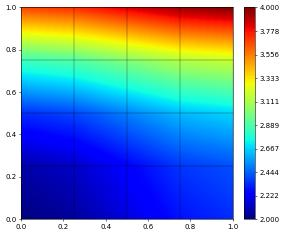

In [2]:
from dune.fem.function import gridFunction
code="""
#include <cmath>
#include <dune/common/fvector.hh>
template <class GridView>
auto aTimesExact(double a) {
  return [a](const auto& en,const auto& xLocal) -> auto {
    auto x = en.geometry().global(xLocal);
    return a*(1./2.*(std::pow(x[0],2)+std::pow(x[1],2)) - 1./3.*(std::pow(x[0],3) - std::pow(x[1],3)) + 1.);
  };
}
"""
exactCpp = gridFunction(code, gridView, name="aTimesExact", order=2, args=[2.])
exactCpp.plot()

Let us implement the same function using `gridFunction` with an ufl
expression and compare the two.

In [3]:
from ufl import SpatialCoordinate
import dune.ufl
from dune.fem import integrate
x = SpatialCoordinate(dune.ufl.domain(2))
exact = (x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
exact_gf = gridFunction(exact, gridView, name="ufl", order=1)
print( integrate(abs(exact-exactCpp)) )

1.0


As the above example shows it is easy to pass in parameters to the C++
implementation - here a double `2`. Note that it is not possible to
obtain a reference to this double. To make sure a change to the
constant on the Python side carries over to the C++ side an option is to
use a `dune.common.FieldVector` or a `numpy` array instead.
These parameters can also be more complex e.g. other grid function -
the generating function can be a template function as shown in the next
example.  Note that an UFL expression can not be directly passed in - it first needs
to be converted into a grid function using `dune.fem.function.gridFunction`:

In [4]:
code2="""
#include <cmath>
#include <dune/common/fvector.hh>
template <class GridView, class GF>
auto aTimesExact(const GF &gf,Dune::FieldVector<double,1> &a) {
  return [lgf=localFunction(gf),&a] (const auto& en,const auto& xLocal) mutable -> auto {

    lgf.bind(en); // lambda must be mutable so that the non const function can be called
    return a[0]*lgf(xLocal);
  };
}
"""
from dune.common import FieldVector
a = FieldVector([2])
exactCpp2 = gridFunction(code2, gridView, name="aTimesExact", order=2, args=[exact_gf,a])
print( integrate(abs(exactCpp-exactCpp2)) )

0.6666666666666666


We can now change the factor ``a`` on the Python side without having to
regenerate the grid function:

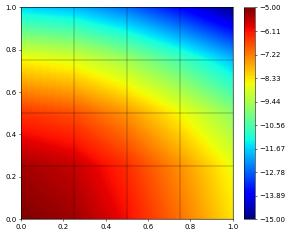

10.999999999999998


In [5]:
a[0] = -5.
exactCpp2.plot()
print( integrate(abs(exactCpp-exactCpp2)) )

In the above example there is no advantage of using the
C++ code over the code generated based on an equivalent UFL expression.
For more complicated functions e.g. with many if statements, loops,
or based on more information from the given element like
it's neighbors the expressibility of UFL might not be sufficient
or would lead to hard to read code.  In these cases directly providing
C++ code can be a reasonable alternative.

We conclude with the example from the
[boundary conditions](boundary_nb.ipynb) section but now defining the
Dirichlet boundary conditions using a C++ code snippet.

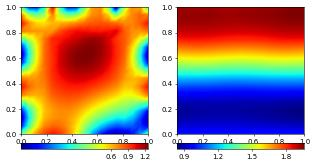

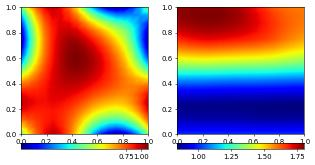

In [6]:
from dune.fem.space import lagrange as solutionSpace
from ufl import TestFunction, TrialFunction, SpatialCoordinate,\
                dx, ds, grad, inner, sin, pi
from dune.fem.scheme import galerkin as solutionScheme
from dune.ufl import DirichletBC, Constant

vecSpace = solutionSpace(gridView, dimRange=2, order=2)
vec = vecSpace.interpolate([0,0], name='u_h')
uVec,vVec = TrialFunction(vecSpace), TestFunction(vecSpace)
a  = inner(grad(uVec), grad(vVec)) * dx
a += ( ( 10*(1-2*uVec[1])+uVec[0] ) * vVec[0] +\
       ( 10*sin(2*pi*x[1]) + (1-2*uVec[0])**2*uVec[1] ) * vVec[1]
     ) * dx
code="""
#include <cmath>
#include <dune/python/pybind11/numpy.h>
template <class GridView>
auto bnd(pybind11::array_t<double> &a, double h) {
  return [ptr=static_cast<double*>(a.request(true).ptr),h](const auto& en,const auto& xLocal) -> auto {
    auto x = en.geometry().global(xLocal);
    return sin(h*M_PI*(ptr[0]*x[0]+ptr[1]*x[1]));
  };
}
"""
coeffVec = numpy.array([5.,-2.])
bndCpp = gridFunction(code, gridView=gridView, name="bnd", order=2, args=[coeffVec,2.])
bcBottom = DirichletBC(vecSpace,[sin(2*pi*(x[0]+x[1])),1],x[1]<1e-10)
bc = DirichletBC(vecSpace,[bndCpp,None])
vecScheme = solutionScheme( [a == 0, bc, bcBottom],
                            parameters={"linear.tolerance": 1e-9} )
vecScheme.solve(target=vec)
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})
coeffVec[:] = numpy.array([1.,1.])
vecScheme.solve(target=vec)
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})